# Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from scipy import stats
from statsmodels.formula.api import ols

# Raw DataFrames

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

# Cleaning steps

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])

In [11]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

In [12]:
temp_county['dt'] = pd.to_datetime(temp_county['dt'], format='%Y/%m/%d')
temp_county['year'] = temp_county['dt'].dt.year

In [13]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820


In [14]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = temp_county_seasons['dt'].dt.month

In [15]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

In [16]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


In [17]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)

In [18]:
temp_county_region['date_delta'] = (temp_county_region['dt'] - temp_county_region['dt'].min())  / np.timedelta64(1,'D')


In [19]:
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,1,Winter,west south central south region,27819.0
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,2,Winter,west south central south region,27850.0
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,3,Spring,west south central south region,27879.0
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,4,Spring,west south central south region,27910.0
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,Fisher County,1820,5,Spring,west south central south region,27940.0


In [20]:
# copy of disaster data to organize for the join
disasterdf = disaster_df.copy()
disasterdf['Declaration Date'] = pd.to_datetime(disasterdf['Declaration Date'], format='%m/%d/%Y')
disasterdf['Year'] = disasterdf['Declaration Date'].dt.year
disasterdf = disasterdf[['Declaration Type','Declaration Date','State','County','Disaster Type','Year']]

In [21]:
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date','Disaster Type','State','Year']).sort_values('Declaration Date')
disasterdf.head()


,Declaration Type,Declaration Date,State,County,Disaster Type,Year
0,Disaster,1953-05-02,GA,NaN,Tornado,1953
1,Disaster,1953-05-15,TX,NaN,Tornado,1953
2,Disaster,1953-05-29,LA,NaN,Flood,1953
3,Disaster,1953-06-02,MI,NaN,Tornado,1953
4,Disaster,1953-06-06,MT,NaN,Flood,1953


In [22]:
# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf = tempdf.sort_values('dt')
tempdf.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,countyname,year,month,season,region,date_delta
365438,1743-11-01,10.572,2.352,Montgomery,United States,32.95N,87.13W,32.95,-87.13,AL,Bibb,Bibb County,1743,11,Fall,east south central south region,0.0
649026,1743-11-01,2.208,1.997,Windsor,United States,42.59N,82.91W,42.59,-82.91,MI,Macomb,Macomb County,1743,11,Fall,east north central midwest region,0.0
652167,1743-11-01,7.810,2.072,Winston Salem,United States,36.17N,79.56W,36.17,-79.56,NC,Guilford,Guilford County,1743,11,Fall,south atlantic south region,0.0
326790,1743-11-01,1.188,1.531,Lowell,United States,42.59N,72.00W,42.59,-72.00,MA,Worcester,Worcester County,1743,11,Fall,new england northeast region,0.0
127176,1743-11-01,10.375,2.313,Columbus,United States,32.95N,85.21W,32.95,-85.21,AL,Chambers,Chambers County,1743,11,Fall,east south central south region,0.0


In [23]:
# nearest join on date (with a left join on state first)
joindf = pd.merge_asof(disasterdf, tempdf, left_on='Declaration Date', right_on='dt',left_by='State',right_by='state',direction='nearest').dropna()


In [24]:
# removing rows where the join dates did not match since the disaster data only went up to Sept 2013
joindf = joindf[joindf['Declaration Date']<='2013-09-30']

In [25]:
joindf = joindf[['Disaster Type','Declaration Date','state','countyname','Year','month','season','region','date_delta','AverageTemperature']]
joindf.head()


,Disaster Type,Declaration Date,state,countyname,Year,month,season,region,date_delta,AverageTemperature
89,Flood,1959-01-29,IN,Decatur County,1959,2.0,Winter,east north central midwest region,78619.0,0.961
181,Flood,1964-12-24,CA,San Diego County,1964,1.0,Winter,pacific west region,80780.0,13.677
182,Flood,1964-12-24,OR,Lane County,1964,1.0,Winter,pacific west region,80780.0,3.656
183,Flood,1964-12-29,WA,King County,1964,1.0,Winter,pacific west region,80780.0,1.133
185,Flood,1965-01-18,NV,Clark County,1965,2.0,Winter,mountain west region,80811.0,8.848


# Statistical Inference

## Average daily temperature, sorted by season

The question that is being examined is how climate change plays into the the natural disasters in the United States. I am looking at the average temperature over time, and in this case, how temperature has been changing by season. 

Text(0.5,1,'Fall')

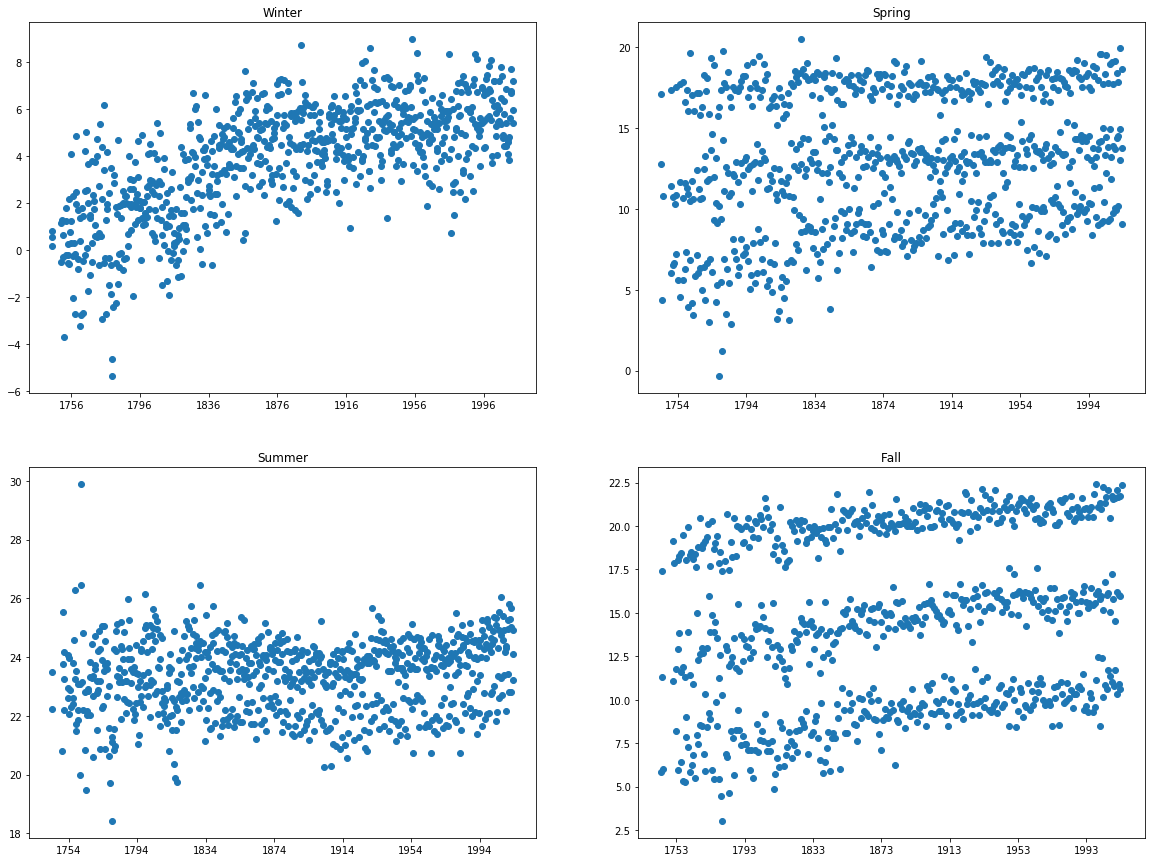

In [26]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[0,0].scatter(winter['dt'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')           

spring = temp_county_region[temp_county_region.season == 'Spring'].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[0,1].scatter(spring['dt'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[1,0].scatter(summer['dt'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[1,1].scatter(fall['dt'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')           
                   
           

These four scatter plots show the correlation of date and average temperature. Each of the temperature values were averaged for a given date, and each season is portrayed. Winter shows a positive correlation of time and temperature, while summer does not show much correlation. Both spring and fall have three bands, which can be attributed to the three months for the given season. Since spring and fall are transition periods between hot and cold seasons, the bands show the changing temperatures. Fall shows some positive correlation within each band, as time goes on, temperature is rising, and a similar trend can be seen with the lower temperatures in spring. Besides summer, there is a visible positive correlation between temperature and time. Summer also shows a slight positive trend, and potentially the ability to fit a polynomial regression (with caution to not overfit). Since there seem to be three distinct groups of data for spring and fall, there may be a better fit of the data by dividing into the three months that the bands represent. 

In [27]:
print('winter corr: ', winter['date_delta'].corr(winter.AverageTemperature),'\n'
      'spring corr: ', spring['date_delta'].corr(spring.AverageTemperature),'\n'
      'summer corr: ', summer['date_delta'].corr(summer.AverageTemperature),'\n'
      'fall corr  : ', fall['date_delta'].corr(fall.AverageTemperature))

winter corr:  0.6772901881046355 
spring corr:  0.20298380917659387 
summer corr:  0.11891006431560357 
fall corr  :  0.2192467943048275


As expected from the visualizations, the winter data shows a positive correlation with a value of 0.677. The winter data can be further examined to construct models to predict the future temperatures during winter.

### Winter Linear Regression

Next, I will perform a linear regression on the winter data to determine the p-value and other coefficients for modeling. 

In [28]:
# set the variables to time and temperature
x = winter[['date_delta']].values
y = winter[['AverageTemperature']].values

In [29]:
# using scipy stats linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000057    intercept: 1.009534    r-squared: 0.458722    p-value: 0.000000


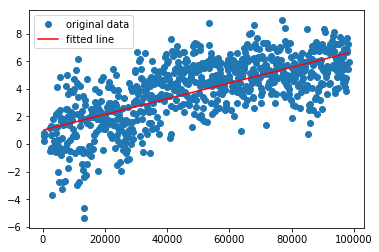

In [30]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

We can see that the p-value is 0, in this case we reject the null hypothesis that the slope is zero. We can say that there is a correlation between days past and temperature, and in this case it is a positive change: as the days increase, the temperature rises. 

### Spring Linear Regression

In [31]:
x = spring[['date_delta']].values
y = spring[['AverageTemperature']].values

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000030    intercept: 11.377628    r-squared: 0.041202    p-value: 0.000000


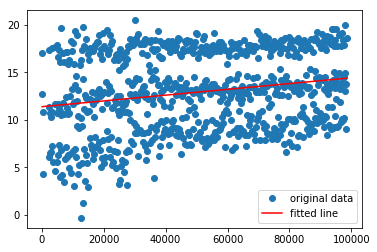

In [33]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

For spring, the r-squared value is close to 0, which indicates a poor fit; however, it averages the best fit between the three bands. I will examine the different months separately to see if a better r-squared value is attainable. 

### Summer Linear Regression

The summer data had the weakest correlation, but a linear regression will be performed to see how a linear model fits the data.

In [34]:
x = summer[['date_delta']].values
y = summer[['AverageTemperature']].values

In [35]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000005    intercept: 23.063908    r-squared: 0.014140    p-value: 0.000863


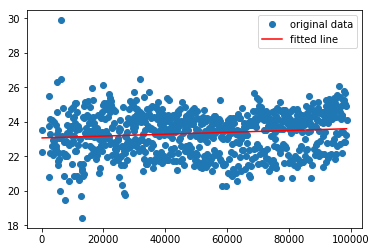

In [36]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

The r-squared value for the summer data is less than that of the spring data, and thus is a very poor fit of the data. However, the p-value is still less than the common threshold of 0.05, which indicates that the null hypothesis can be rejected and that the slope is a positive value, not zero.

### Fall Linear Regression

In [37]:
x = fall[['date_delta']].values
y = fall[['AverageTemperature']].values

In [38]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000038    intercept: 12.620549    r-squared: 0.048069    p-value: 0.000000


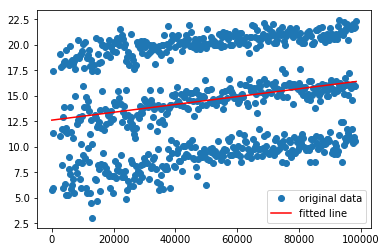

In [39]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

As with spring, I will examine the fall data in separate months to obtain a better model.

## Average daily temperature, sorted by month

I will now explore average temperature as it changes over time for each month. These separations will be useful for the spring and fall seasons, where the banding occurred.

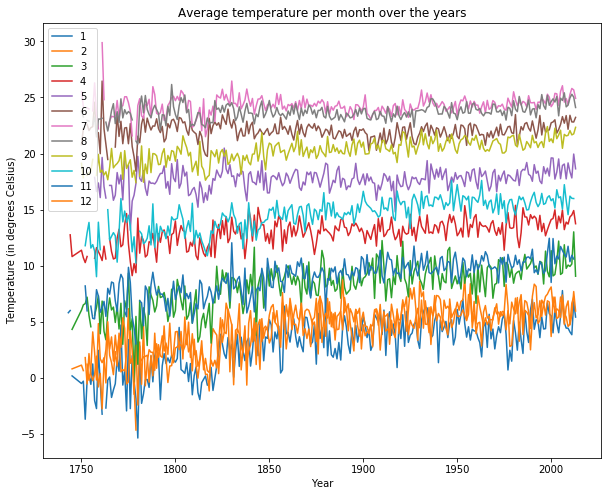

In [40]:
# temperature over time by month
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','month']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per month over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

It can be observed that the summer months (July, August, and June) have the highest average temperature over the years and the winter months (January, February, and December) have the lowest temperatures. This follows the expected trend, but the question of is the average temperature increasing over time is still unknown, without some statistical analysis. 

Text(0.5,1,'November')

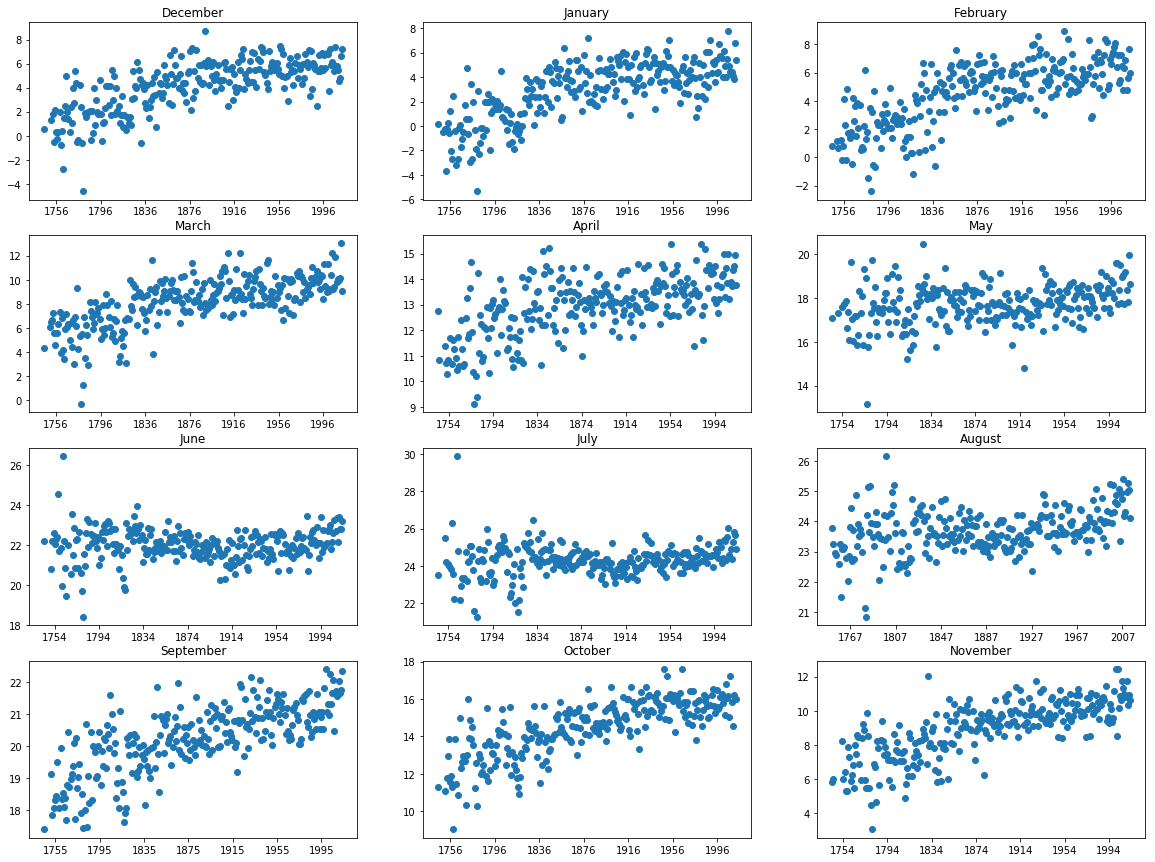

In [41]:
fig, ax = plt.subplots(4,3,figsize=(20,15))

dec = temp_county_region[temp_county_region.month == 12].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[0,0].scatter(dec['dt'].tolist() ,dec['AverageTemperature'].tolist())
ax[0,0].set_title('December')           
                    
jan = temp_county_region[temp_county_region.month == 1].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[0,1].scatter(jan['dt'].tolist() ,jan['AverageTemperature'].tolist())
ax[0,1].set_title('January')       

feb = temp_county_region[temp_county_region.month == 2].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[0,2].scatter(feb['dt'].tolist() ,feb['AverageTemperature'].tolist())
ax[0,2].set_title('February')       


mar = temp_county_region[temp_county_region.month == 3].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[1,0].scatter(mar['dt'].tolist() ,mar['AverageTemperature'].tolist())
ax[1,0].set_title('March')           
                    
apr = temp_county_region[temp_county_region.month == 4].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[1,1].scatter(apr['dt'].tolist() ,apr['AverageTemperature'].tolist())
ax[1,1].set_title('April')       

may = temp_county_region[temp_county_region.month == 5].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[1,2].scatter(may['dt'].tolist() ,may['AverageTemperature'].tolist())
ax[1,2].set_title('May')


jun = temp_county_region[temp_county_region.month == 6].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[2,0].scatter(jun['dt'].tolist() ,jun['AverageTemperature'].tolist())
ax[2,0].set_title('June')           
                    
jul = temp_county_region[temp_county_region.month == 7].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[2,1].scatter(jul['dt'].tolist() ,jul['AverageTemperature'].tolist())
ax[2,1].set_title('July')       

aug = temp_county_region[temp_county_region.month == 8].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[2,2].scatter(aug['dt'].tolist() ,aug['AverageTemperature'].tolist())
ax[2,2].set_title('August')


sep = temp_county_region[temp_county_region.month == 9].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[3,0].scatter(sep['dt'].tolist() ,sep['AverageTemperature'].tolist())
ax[3,0].set_title('September')           
                    
octo = temp_county_region[temp_county_region.month == 10].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[3,1].scatter(octo['dt'].tolist() ,octo['AverageTemperature'].tolist())
ax[3,1].set_title('October')       

nov = temp_county_region[temp_county_region.month == 11].groupby(['dt','date_delta']).mean()[['AverageTemperature']].reset_index()
ax[3,2].scatter(nov['dt'].tolist() ,nov['AverageTemperature'].tolist())
ax[3,2].set_title('November')

In [42]:
print('dec corr: ', dec['date_delta'].corr(dec.AverageTemperature),'\n'
      'jan corr: ', jan['date_delta'].corr(jan.AverageTemperature),'\n'
      'feb corr: ', feb['date_delta'].corr(feb.AverageTemperature),'\n'
      'mar corr: ', mar['date_delta'].corr(mar.AverageTemperature),'\n'
      'apr corr: ', apr['date_delta'].corr(apr.AverageTemperature),'\n'
      'may corr: ', may['date_delta'].corr(may.AverageTemperature),'\n'
      'jun corr: ', jun['date_delta'].corr(jun.AverageTemperature),'\n'
      'jul corr: ', jul['date_delta'].corr(jul.AverageTemperature),'\n'
      'aug corr: ', aug['date_delta'].corr(aug.AverageTemperature),'\n'
      'sep corr: ', sep['date_delta'].corr(sep.AverageTemperature),'\n'
      'octo corr: ', octo['date_delta'].corr(octo.AverageTemperature),'\n'
      'nov corr: ', nov['date_delta'].corr(nov.AverageTemperature))
      

dec corr:  0.7100828393861939 
jan corr:  0.7122962896571023 
feb corr:  0.7031974899961514 
mar corr:  0.6871124876787403 
apr corr:  0.5889090227838704 
may corr:  0.2949557374427319 
jun corr:  0.03759907164053093 
jul corr:  0.1675456841674064 
aug corr:  0.35875306115325023 
sep corr:  0.731934086893254 
octo corr:  0.7530410015644486 
nov corr:  0.7571744194953911


These are the correlations of average temperature over datetime for each month. Visually, most months, except summer, show a positive, linear correlation. However, around May-August, there is a curving feature where the temperature around the late 1800s starts to decrease. These correlations show that there is a positive correlation, thus they serve useful to show that in general, temperature has been increasing with time.

The next series of months show the individual bands from above. I will be looking at the p-value and r-squared to see the significance of the slope and how well the data was fit by the linear regression model.

### spring months - march

In [43]:
x = mar[['date_delta']].values
y = mar[['AverageTemperature']].values

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000050    intercept: 5.666613    r-squared: 0.472124    p-value: 0.000000


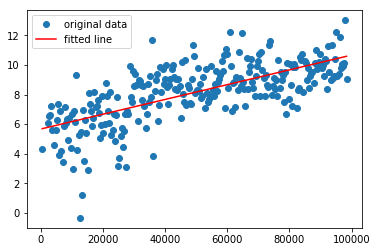

In [45]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### spring months - april

In [46]:
x = apr[['date_delta']].values
y = apr[['AverageTemperature']].values

In [47]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000025    intercept: 11.690470    r-squared: 0.346814    p-value: 0.000000


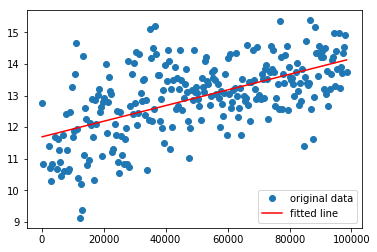

In [48]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### spring months - may

In [49]:
x = may[['date_delta']].values
y = may[['AverageTemperature']].values

In [50]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000010    intercept: 17.221824    r-squared: 0.086999    p-value: 0.000001


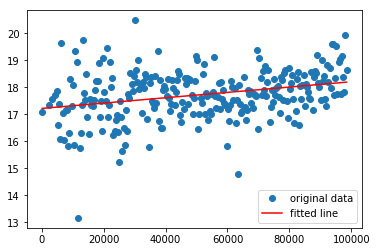

In [51]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### fall months - september

In [52]:
x = sep[['date_delta']].values
y = sep[['AverageTemperature']].values

In [53]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000028    intercept: 18.815063    r-squared: 0.535728    p-value: 0.000000


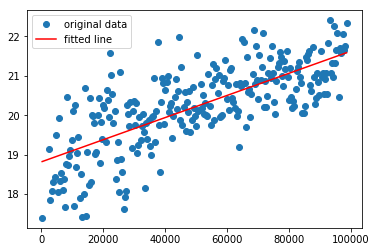

In [54]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### fall months - october

In [55]:
x = octo[['date_delta']].values
y = octo[['AverageTemperature']].values

In [56]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000041    intercept: 12.457512    r-squared: 0.567071    p-value: 0.000000


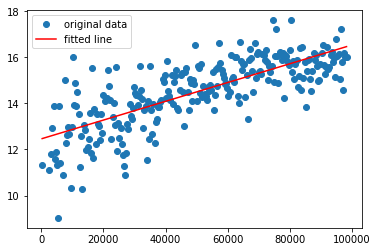

In [57]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

### fall months - november

In [58]:
x = nov[['date_delta']].values
y = nov[['AverageTemperature']].values

In [59]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.000046    intercept: 6.608603    r-squared: 0.573313    p-value: 0.000000


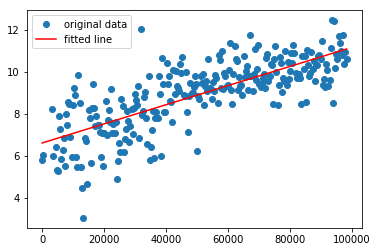

In [60]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

Overall, the months of March-May and September-November showed a p-value of 0, indicating the slope is some non-zero value and that the null hypothesis is rejected. Additionally, the r-squared values were worse as the months tended towards summer, thus May and September had the lowest r-squared values from their respective seasons. Also, the fall months had a higher overall r-squared value. This indicates that the linear regression fit those datasets better than the spring months. Further models can be used of these months to predict the temperature for a given season or month.

## Average daily temperature, sorted by region

In [61]:
# nine regions of the United States
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'].groupby('year').mean()[['AverageTemperature']].reset_index()

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'].groupby('year').mean()[['AverageTemperature']].reset_index()

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'].groupby('year').mean()[['AverageTemperature']].reset_index()

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'].groupby('year').mean()[['AverageTemperature']].reset_index()


In [62]:
print('enc corr: ', enc_midwest_region['year'].corr(enc_midwest_region.AverageTemperature),'\n'
      'esc corr: ', esc_south_region['year'].corr(esc_south_region.AverageTemperature),'\n'
      'mid corr: ', mid_northeast_region['year'].corr(mid_northeast_region.AverageTemperature),'\n'
      'mt corr: ', mt_west_region['year'].corr(mt_west_region.AverageTemperature),'\n'
      'ne corr: ', ne_northeast_region['year'].corr(ne_northeast_region.AverageTemperature),'\n'
      'pac corr: ', pac_west_region['year'].corr(pac_west_region.AverageTemperature),'\n'
      'sa corr: ', sa_south_region['year'].corr(sa_south_region.AverageTemperature),'\n'
      'wnc corr: ', wnc_midwest_region['year'].corr(wnc_midwest_region.AverageTemperature),'\n'
      'wsc corr: ', wsc_south_region['year'].corr(wsc_south_region.AverageTemperature),'\n')

enc corr:  0.4030379883249252 
esc corr:  0.43415441337079186 
mid corr:  0.48081285359265274 
mt corr:  0.6734878949707309 
ne corr:  0.49294117838291945 
pac corr:  0.6427530117788472 
sa corr:  0.5347502345372169 
wnc corr:  0.5768741511922301 
wsc corr:  0.5638639630474188 



Seeing that the regions have a positive medium-strong correlation with temperature over time in years, I can use the region divisions to model the predicted temperature in these regions and then use that model with the disaster that is likely to be found in that region and determine future information about the disaster data. 

Below are the nine regions and their r-squared values and p-values. Same with the month data, the p-values are zero, thus rejecting the slope of zero hypothesis. One feature that appears in some of the regions are outliers in the beginning of the data. These points have an affect on the linear regression fit to the data, and if needed, further analysis can be done to properly omit outliers. 

#### East North Central Midwest Region

In [63]:
x = enc_midwest_region[['year']].values
y = enc_midwest_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.006108    intercept: -1.976346    r-squared: 0.162440    p-value: 0.000000


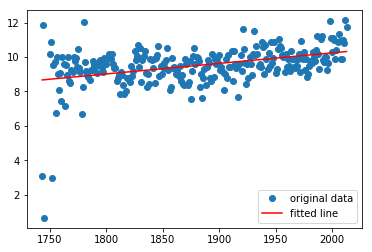

In [64]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### East South Central South Region

In [65]:
x = esc_south_region[['year']].values
y = esc_south_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.006449    intercept: 3.050821    r-squared: 0.188490    p-value: 0.000000


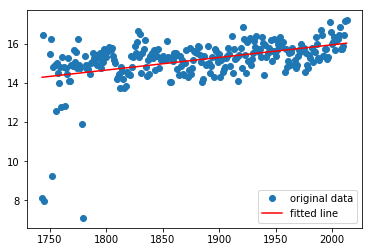

In [66]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### Middle Atlantic Northeast Region

In [67]:
x = mid_northeast_region[['year']].values
y = mid_northeast_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.007346    intercept: -4.296693    r-squared: 0.231181    p-value: 0.000000


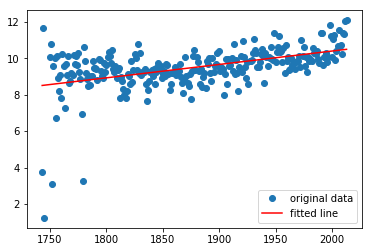

In [68]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### Mountain West Region

In [69]:
x = mt_west_region[['year']].values
y = mt_west_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.025017    intercept: -34.345350    r-squared: 0.453586    p-value: 0.000000


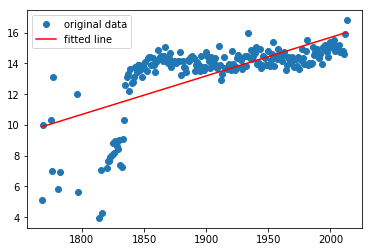

In [70]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### New England Northeast Region

In [71]:
x = ne_northeast_region[['year']].values
y = ne_northeast_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.008485    intercept: -8.697996    r-squared: 0.242991    p-value: 0.000000


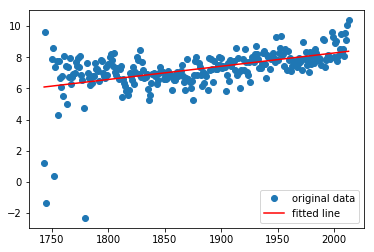

In [72]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### Pacific West Region

In [73]:
x = pac_west_region[['year']].values
y = pac_west_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.036179    intercept: -56.103881    r-squared: 0.413131    p-value: 0.000000


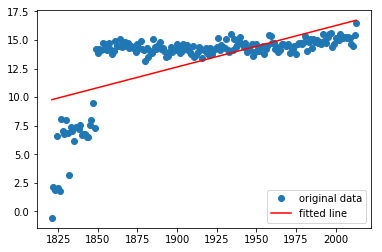

In [74]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### South Atlantic South Region

In [75]:
x = sa_south_region[['year']].values
y = sa_south_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.008675    intercept: 1.482313    r-squared: 0.285958    p-value: 0.000000


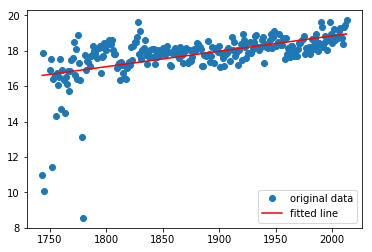

In [76]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### West North Central Midwest Region

In [77]:
x = wnc_midwest_region[['year']].values
y = wnc_midwest_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.013400    intercept: -15.667243    r-squared: 0.332784    p-value: 0.000000


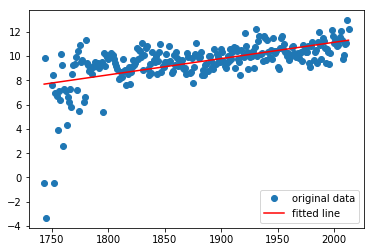

In [78]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

#### West South Central South Region

In [79]:
x = wsc_south_region[['year']].values
y = wsc_south_region[['AverageTemperature']].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x[:,0], y[:,0])
print("slope: %f    intercept: %f    r-squared: %f    p-value: %f" % (slope, intercept, r_value**2, p_value))

slope: 0.014161    intercept: -8.855981    r-squared: 0.317943    p-value: 0.000000


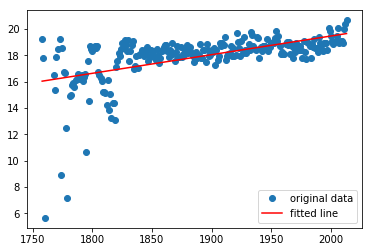

In [80]:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

# Disaster data

Part of the hypothesis is to see if natural disasters in the United States have increased due to temperature changes. To examine the disaster side, I will look at the disaster data frame and see how disasters have changed over time. 

In [81]:
# count total number of disasters, see which disasters are most prevalent
disasterdf.groupby('Disaster Type').agg('count')['Declaration Type'].sort_values(ascending=False).head()


Disaster Type
Storm        919
Flood        772
Fire         680
Hurricane    313
Tornado      163
Name: Declaration Type, dtype: int64

The first five disasters with the most occurences in the United States are: storms, floods, fires, hurricanes, and tornados. I will focus on these disasters to examine the trends in the data, since they make up most of the data.

### Joined temperature and disaster data

To view correlations between temperature and disaster I will use the joined dataframe.

In [82]:
joindf.tail()

,Disaster Type,Declaration Date,state,countyname,Year,month,season,region,date_delta,AverageTemperature
3104,Flood,2013-09-12,CO,Elbert County,2013,9.0,Fall,mountain west region,98555.0,19.373
3105,Flood,2013-09-14,CO,Elbert County,2013,9.0,Fall,mountain west region,98555.0,19.373
3106,Flood,2013-09-25,NC,Guilford County,2013,9.0,Fall,south atlantic south region,98555.0,21.692
3107,Storm,2013-09-27,NM,Valencia County,2013,9.0,Fall,mountain west region,98555.0,19.207
3108,Storm,2013-09-30,NM,Valencia County,2013,9.0,Fall,mountain west region,98555.0,19.207


Text(0.5,1,'Average Yearly Temperature vs Disaster Count')

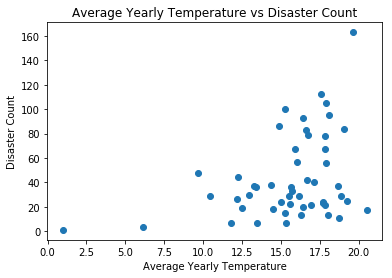

In [83]:
# average yearly temperature against disaster count 
joindf1 = joindf.groupby('Year').agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})

plt.scatter(joindf1['AverageTemperature'], joindf1['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs Disaster Count')

In [84]:
joindf1.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.363697
AverageTemperature,0.363697,1.000000


This scatterplot is the yearly average temperature against the disaster count across the nation. There is small positive correlation between the average temperature and disaster count.

Furthermore, I will look at specific regions, or a couple of regions, and look at the disasters prone to each region. For example, hurricanes occur mostly on the east coast, so I will look at those states and that specific disaster. I will go through the top five disasters (storms, floods, fires, hurricanes, and tornados) and their respective regions. 

### Storms

Text(0,0.5,'Disaster Count')

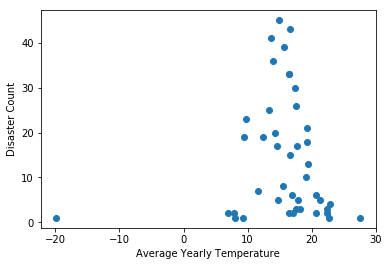

In [85]:
# storm count by year for all regions
stormdf = joindf[(joindf['Disaster Type']=='Storm')]
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [86]:
stormdf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.00000,0.00977
AverageTemperature,0.00977,1.00000


In [87]:
# regional count of storms over time
joindf[joindf['Disaster Type']=='Storm']['region'].value_counts().head()

east south central south region      116
west north central midwest region    107
east north central midwest region     98
west south central south region       90
south atlantic south region           68
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

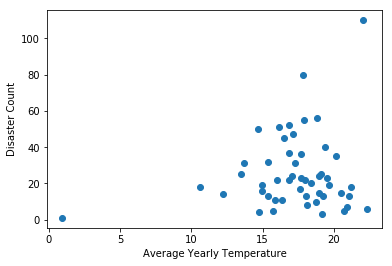

In [88]:
# storm count by year for top 5 regions with the most storms
stormdf = joindf[(joindf['Disaster Type']=='Storm')&
                 (joindf['region'].str.contains('east south central south region'))|
                 (joindf['region'].str.contains('west north central midwest region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))]
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [89]:
stormdf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.171993
AverageTemperature,0.171993,1.000000


### Floods

Text(0,0.5,'Disaster Count')

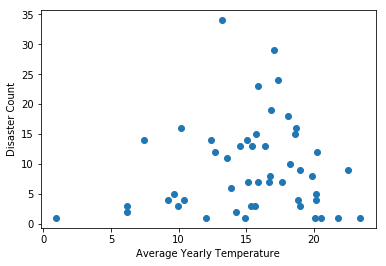

In [90]:
# flood count by year for all regions
flooddf = joindf[(joindf['Disaster Type']=='Flood')]
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [91]:
flooddf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.065265
AverageTemperature,0.065265,1.000000


In [92]:
# regional count of floods over time
joindf[joindf['Disaster Type']=='Flood']['region'].value_counts().head()

west south central south region      80
pacific west region                  73
west north central midwest region    67
east north central midwest region    59
mountain west region                 50
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

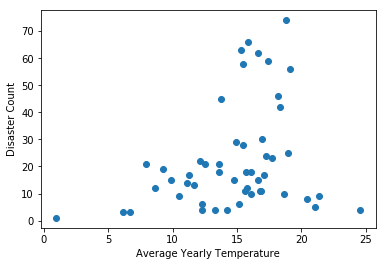

In [93]:
# flood count by year for top 5 regions with the most storms
flooddf = joindf[(joindf['Disaster Type']=='Storm')&
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('pacific west region'))|
                 (joindf['region'].str.contains('west north central midwest region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('mountain west region'))]
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [94]:
flooddf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.283134
AverageTemperature,0.283134,1.000000


### Fires

Text(0,0.5,'Disaster Count')

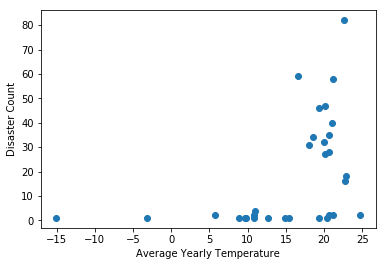

In [95]:
# fire count by year for all regions
firedf = joindf[(joindf['Disaster Type']=='Fire')]
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [96]:
firedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.443328
AverageTemperature,0.443328,1.000000


In [97]:
# regional count of fire over time
joindf[joindf['Disaster Type']=='Fire']['region'].value_counts().head()

pacific west region                174
mountain west region               170
west south central south region    151
south atlantic south region         57
east south central south region     12
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

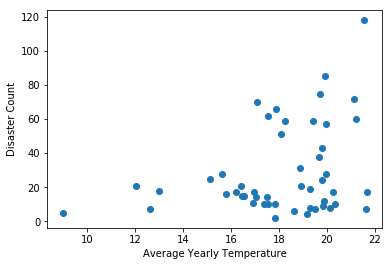

In [98]:
# fire count by year for top 5 regions with the most storms
firedf = joindf[(joindf['Disaster Type']=='Fire')&
                 (joindf['region'].str.contains('pacific west region'))|
                 (joindf['region'].str.contains('mountain west region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))|
                 (joindf['region'].str.contains('east south central south region'))]
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [99]:
firedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.315015
AverageTemperature,0.315015,1.000000


### Hurricanes

Text(0,0.5,'Disaster Count')

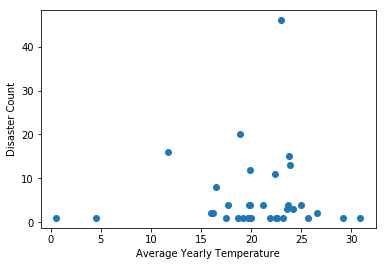

In [100]:
# hurricane count by year for all regions
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')]
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [101]:
hurricanedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.043427
AverageTemperature,0.043427,1.000000


In [102]:
# regional count of hurricanes over time
joindf[joindf['Disaster Type']=='Hurricane']['region'].value_counts().head()

south atlantic south region        78
west south central south region    40
east south central south region    33
midatlantic northeast region       18
new england northeast region        8
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

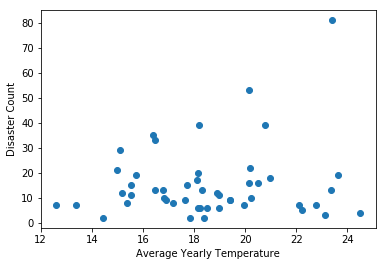

In [103]:
# hurricane count by year for top 3 regions with the most storms
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')&
                 (joindf['region'].str.contains('south atlantic south region'))|
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('east south central south region'))]
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [104]:
hurricanedf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.148129
AverageTemperature,0.148129,1.000000


### Tornados 

Text(0,0.5,'Disaster Count')

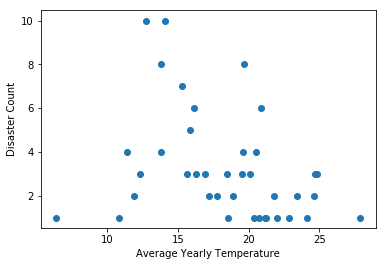

In [105]:
# tornado count by year for all regions
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')]
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [106]:
tornadodf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,-0.329665
AverageTemperature,-0.329665,1.000000


In [107]:
# regional count of tornados over time
joindf[joindf['Disaster Type']=='Tornado']['region'].value_counts().head()

west south central south region      39
east north central midwest region    28
east south central south region      24
south atlantic south region          17
west north central midwest region    16
Name: region, dtype: int64

Text(0,0.5,'Disaster Count')

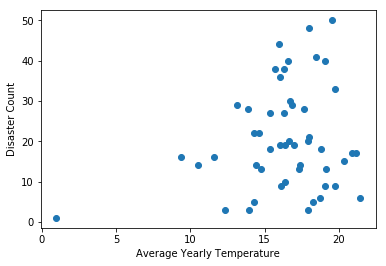

In [108]:
# tornado count by year for top 3 regions with the most storms
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')&
                 (joindf['region'].str.contains('west south central south region'))|
                 (joindf['region'].str.contains('east north central midwest region'))|
                 (joindf['region'].str.contains('east south central south region'))|
                 (joindf['region'].str.contains('south atlantic south region'))|
                (joindf['region'].str.contains('west north central midwest region'))]
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                              'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')

In [109]:
tornadodf.corr()

,Disaster Type,AverageTemperature
Disaster Type,1.000000,0.209709
AverageTemperature,0.209709,1.000000


Except for fires, when the top regions with the most number of disasters was selected, the correlation increased. Thus, I will focus on the regions where some natural disasters are more likely to occur. For example, the top 5 regions with tornados were in the midwest and south, which is consistent with what we know about where tornados usually hit. Thus with future modeling, I will use select regions with select natural disasters since not all disasters occur all over the united states.